In [54]:
import math
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import copy

def cov(x, y):
    #definition of cov(x, y) = E[xy] - E[x]E[y]
    return np.mean(x * y) - np.mean(x) * np.mean(y)

def corr(x, y):
    #corr(x, y) = cov(x, y) / sqrt(var(x) * var(y))
    #var(y) == 0 --> this edge case is checked in the decision tree algorithm
    #var(y) == 0 --> implies very high correlation in that set of data
    #var(x) == 0 --> implies very low correlation in that set of data (hence we return 0 on this)
    if np.var(x) == 0:
        return 0
    return cov(x, y) / math.sqrt(np.var(x) * np.var(y))

def generate_data(size, d):
    x = []
    x.append(np.random.normal(3, 1, size))
    x.append(np.random.normal(-2, 1, size))
    x.append(x[0] + 2 * x[1])
    x.append((x[1] + 2)**2)
    x.append(np.random.binomial(n=1, p=0.8, size=size))
    for _ in range(d - 5):
        x.append(np.random.normal(0, 0.1, size))

    def compute_y(x):
        y = 4 - 3 * x[0] * x[0] + x[2] - 0.01 * x[3] + x[1] * x[4] + np.random.normal(0, 0.1, len(x[0]))
        return y
    
    def transpose(temp):
        temp = np.array(temp)
        return temp.T
    
    xt = transpose(x)
    y = compute_y(x)
    
    return x, xt, y

In [55]:
class DecisionTree():   
    superfluous = defaultdict(int)
    def __init__(self, x, y, d, max_depth, min_sample_size):
        self.x = x
        self.y = y
        
        self.max_depth = max_depth
        self.min_sample_size = min_sample_size
        self.depth = d 
        self.child = len(self.x[0]) <= self.min_sample_size or self.depth == self.max_depth or np.var(y) == 0
        
        self.ind = -1
        self.threshold = 0
        
        self.result = np.mean(y)
        self.left, self.right = None, None

        if not self.child:
            self.split()
    
    def find_best_feature(self):
        all_corr = [abs(corr(xi, self.y)) for xi in self.x]
        return np.argmax(all_corr)
    
    def find_threshold_split(self, ind):
        indices = self.x[ind].argsort()
        
        for i in range(len(self.x)):
            self.x[i] = self.x[i][indices]
        self.y = self.y[indices]
        
        threshold = -1
        mn = float('inf')

        for i in range(1, len(self.y) - 1):
            fltr_left = self.x[ind] <= self.x[ind][i]
            fltr_right = self.x[ind] > self.x[ind][i]
            
            var_left = np.var(self.y[fltr_left])
            var_right = np.var(self.y[fltr_right])
            
            left = np.sum(fltr_left)
            right = np.sum(fltr_right)
            
            err_left = left / len(self.y) * var_left
            err_right = right / len(self.y) * var_right
            
            err = err_left + err_right
            
            if err < mn:
                threshold, mn = (self.x[ind][i] + self.x[ind][i + 1]) / 2, err
        return threshold
    
     
    def split(self):
        self.ind = self.find_best_feature()
        self.superfluous[self.ind] += 1

        self.threshold = self.find_threshold_split(self.ind)

        fltr_left = self.x[self.ind] <= self.threshold
        fltr_right = self.x[self.ind] > self.threshold
        
        x_left = [arr[fltr_left] for arr in self.x]
        x_right = [arr[fltr_right] for arr in self.x]
        
        y_left = self.y[fltr_left]
        y_right = self.y[fltr_right]

        self.left = DecisionTree(x_left, y_left, self.depth + 1, self.max_depth, self.min_sample_size)
        self.right = DecisionTree(x_right, y_right, self.depth + 1, self.max_depth, self.min_sample_size)

    @staticmethod
    def predict(node, arr):
        if node.child:
            return node.result
        if arr[node.ind] <= node.threshold:
            return DecisionTree.predict(node.left, arr)
        else:
            return DecisionTree.predict(node.right, arr)

def compute_mse_dt(x, y, dt):
    err = 0 #error
    for i in range(len(y)):
        yp = DecisionTree.predict(dt, x[i]) #get prediction from decision tree
        err += (abs(yp - y[i]) ** 2) #add squared error
    err = err / len(y) #take mean of squared error
    return err


In [56]:
def question3():

    train_errors = []
    test_errors = []
    
    #set of sample sizes that we will build decision trees out of
    #note that these are a set of decreasing and somewhat random numbers (more explanation in pdf)
    sample_sizes = [1]
    
    #generate dataset
    #x and y are used for the decision tree
    #xt is transpose of training dataset
    #tx (transpose of test dataset) and testy are a part of testing dataset
    x, xt, y = generate_data(10000, 10)
    _, tx, testy = generate_data(1000, 10)

    for sample_size in sample_sizes: #iterate through each sample size
        #build decision tree with copies of dataset
        dt = DecisionTree(copy.deepcopy(x), copy.deepcopy(y), 1, 150, sample_size)
        
        #compute and store errors
        training_err = compute_mse_dt(xt, y, dt)
        test_err = compute_mse_dt(tx, testy, dt)
        train_errors.append(training_err)
        test_errors.append(test_err)
    
    #build plots
    plt.figure(figsize = (6, 10), dpi=80)
    plt.title('Training/Testing MSE on Decision Tree with varying sample size')
    plt.plot(sample_sizes, train_errors, '-b', label = 'Train')
    plt.plot(sample_sizes, test_errors, '--r', label = 'Test')
    plt.xlabel('Sample Size')
    plt.ylabel('Training/Testing MSE')
    plt.legend()
    plt.show()
    
    return train_errors, test_errors

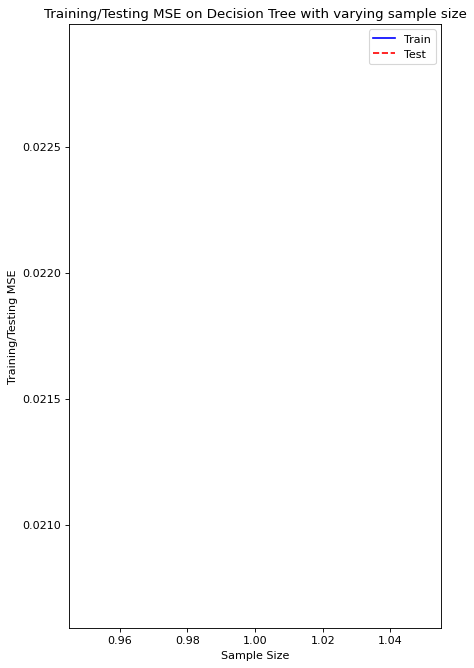

In [57]:
train, test = question3()

In [59]:
print(train)
print(test)

[0.021788911352048353]
[nan]


In [20]:
for i in range(len(train)):
    print(train[i], ' ', test[i])

310.69236186746707   332.62430352244655
79.70733941260833   91.96267582295245
31.800744209685014   36.154470644273715
20.382941058579217   25.64562683434249
9.159044910715224   11.890220594535805
5.526411319757641   8.237207559697318
4.5869097165976225   7.079134817435953
2.8756483928801324   3.8909231588159927
1.9866274757221631   2.660294927954254
1.2500923864635922   1.9101355505719353
0.47291717610320905   0.852538243761284
0.39383370238609766   0.7453791097617645
0.2939835969677614   0.611929430368408
0.19625580085738403   0.5240694018073562
0.052316749828285616   0.5225178271376913
0.03641339693417548   0.5240164236243224
0.02100154833952384   0.5283483463683104
0.005859477935241156   0.5108923506988158
0.0   0.5191943245932403


In [43]:
arr = []
arr = np.array(arr)
urmom = [True, False]
arr[urmom]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 2

In [60]:
sample_sizes = [10000, 5000, 2500, 1250, 625, 300, 200, 150, 100, 50, 25, 20, 15, 10, 5, 4, 3, 2, 1]

In [62]:
x, xt, y = generate_data(10000, 10)
_, tx, testy = generate_data(1000, 10)
dt = DecisionTree(copy.deepcopy(x), copy.deepcopy(y), 1, 150, 1)
        
        #compute and store errors
training_err = compute_mse_dt(xt, y, dt)
test_err = compute_mse_dt(tx, testy, dt)
print(training_err)
print(test_err)

KeyboardInterrupt: 